In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import shap

In [2]:
#Reading dataset
df=pd.read_csv('Morgan_desc.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 2049 entries, Yield to 1023.1
dtypes: int64(2049)
memory usage: 1.1 MB


In [3]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 1914 variables with zero variance
the number of variable is: [   1    2    3 ... 2046 2047 2048]
remove them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 135 entries, Yield to 919.1
dtypes: int64(135)
memory usage: 71.8 KB


In [4]:
#Building descriptors
X = df_var0.drop(columns=['Yield'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   8  9  15  33  58  63  64  68  80  102  ...  623.1  665.1  695.1  726.1  \
0  0  0   0   0   0   0   1   0   0    0  ...      1      1      1      0   
1  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      0   
2  0  0   0   0   0   0   1   0   0    0  ...      1      0      0      1   
3  0  0   0   0   0   0   1   0   0    0  ...      0      0      0      0   
4  0  0   0   1   0   0   0   0   0    0  ...      1      1      1      0   

   755.1  802.1  807.1  841.1  849.1  919.1  
0      0      1      0      1      0      0  
1      1      0      1      0      0      0  
2      0      0      1      0      1      1  
3      0      0      1      0      0      0  
4      0      1      0      1      0      0  

[5 rows x 134 columns]
---Objective---
   Yield
0     80
1      7
2      3
3     48
4     99


In [12]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_shap = np.zeros((47,160))
loo_score = []
#MLP
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 
    a_X_train=a_X_train.dropna(axis=1)
    a_X_test=a_X_test[a_X_train.columns]
    
    a_y_train = y_train / 10

    param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
               'learning_rate_init':[0.003,0.03]}
    
    reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
    reg_mlp.fit(a_X_train,a_y_train['Yield'])
    reg_best = reg_mlp.best_estimator_
    y_pred1 = reg_best.predict(a_X_train)*10
    y_pred2 = reg_best.predict(a_X_test)*10
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    #strage data of accuracy 
    parametors = reg_mlp.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_mlp.best_score_)

    print('----------------------')
    print('seed:', seed)
    print('X_dim.',len(X_train.columns))
    print("Best Model Parameter:",reg_mlp.best_params_)
    print("Best Model Score:",reg_mlp.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
X_dim. 134
Best Model Parameter: {'alpha': 2, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.6865535675501324
R2_test: 0.6466153731198592
----------------------
seed: 1
X_dim. 134
Best Model Parameter: {'alpha': 1, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.6639172235137452
R2_test: 0.6407250182007265
----------------------
seed: 2
X_dim. 134
Best Model Parameter: {'alpha': 5, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.6201561213077165
R2_test: 0.7702221087190687
----------------------
seed: 3
X_dim. 134
Best Model Parameter: {'alpha': 4, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.6190930316497025
R2_test: 0.7699914876958953
----------------------
seed: 4
X_dim. 134
Best Model Parameter: {'alpha': 4, 'hidden_layer_sizes': (400,), 'learning_r

In [14]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
best_model_parametors = []
data_cv_score = []
cum_shap = np.zeros((47,160))
loo_score = []
#MLP
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
               'learning_rate_init':[0.003,0.03]}
    
    reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
    reg_mlp.fit(X_train,y_train['Yield'])
    reg_best = reg_mlp.best_estimator_
    y_pred1 = reg_best.predict(X_train)
    y_pred2 = reg_best.predict(X_test)
            
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

    #strage data of accuracy 
    parametors = reg_mlp.best_params_
    best_model_parametors.append(parametors)

    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    data_cv_score.append(reg_mlp.best_score_)

    print('----------------------')
    print('seed:', seed)
    print('X_dim.',len(X_train.columns))
    print("Best Model Parameter:",reg_mlp.best_params_)
    print("Best Model Score:",reg_mlp.best_score_)
    print('R2_test:', r2_test)
print('R2_train_means:', sum(data_r2_train)/10)
print('CV_score_means:', sum(data_cv_score)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
X_dim. 134
Best Model Parameter: {'alpha': 1, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.8020897244318013
R2_test: 0.6676656065648148
----------------------
seed: 1
X_dim. 134
Best Model Parameter: {'alpha': 3, 'hidden_layer_sizes': (400,), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.7367779673926979
R2_test: 0.790157015201804
----------------------
seed: 2
X_dim. 134
Best Model Parameter: {'alpha': 1, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.003, 'max_iter': 5000}
Best Model Score: 0.6776299440333519
R2_test: 0.7964982291983089
----------------------
seed: 3
X_dim. 134
Best Model Parameter: {'alpha': 2, 'hidden_layer_sizes': (32, 32, 32, 32), 'learning_rate_init': 0.03, 'max_iter': 5000}
Best Model Score: 0.665170434214214
R2_test: 0.811062576369151
----------------------
seed: 4
X_dim. 134
Best Model Parameter: {'alpha': 1, 'hidden_layer_sizes': (

In [7]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['MSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
data_cv_score_pd = pd.DataFrame(data=data_cv_score, columns=['cv_score'])
data_parametors = pd.DataFrame([best_model_parametors])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd, data_RMSE_test_pd, data_MAE_test_pd, data_cv_score_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)
data_all.to_csv('../../score/MorganF/MLP_score.csv')
#data_parametors.to_csv('../../score/MorganF/MLP_parametors.csv')

      r2_train  MSE_train  MAE_train   r2_test    MSE_test   MAE_test  \
0     0.999955   0.033272   0.152159  0.667666  434.676808  13.994927   
1     0.999871   0.117094   0.241421  0.790157  203.305971   9.678798   
2     0.999996   0.003884   0.052326  0.796498  196.798672   9.471671   
3     0.998997   0.935923   0.809442  0.811063  181.331943   8.684085   
4     0.999979   0.017773   0.093444  0.791718  221.471694  10.344783   
5     0.999669   0.268314   0.339896  0.848345  184.443739   8.554221   
6     0.999384   0.505335   0.528430  0.811096  227.338670  10.134877   
7     0.999996   0.003353   0.046216  0.625784  339.229425  12.684542   
8     0.999996   0.003192   0.047024  0.723526  273.221206  12.329239   
9     0.999844   0.157740   0.342778  0.877970   85.989132   6.062131   
mean  0.999769   0.204588   0.265313  0.774382  234.780726  10.193927   

      cv_score  
0     0.802090  
1     0.736778  
2     0.677630  
3     0.665170  
4     0.734251  
5     0.737811  
6   

In [10]:
seed=9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#autoscaling
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1) 
a_X_train=a_X_train.dropna(axis=1)
a_X_test=a_X_test[a_X_train.columns]
    
a_y_train = y_train / 10

param_mlp={'hidden_layer_sizes':[(32,32,32,32,),(400,)], 'alpha':[1,2,3,4,5], 'max_iter':[5000],
           'learning_rate_init':[0.003,0.03]}
    
reg_mlp = GridSearchCV(MLPRegressor(random_state=0), param_grid=param_mlp, cv=5, n_jobs=2)
reg_mlp.fit(a_X_train,a_y_train['Yield'])
reg_best = reg_mlp.best_estimator_
y_pred1 = reg_best.predict(a_X_train)*10
y_pred2 = reg_best.predict(a_X_test)*10
            
#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
print('R2_train:', r2_train)
print('R2_test:', r2_test)

R2_train: 0.9847055673032569
R2_test: 0.7488732889383816


  0%|          | 0/47 [00:00<?, ?it/s]

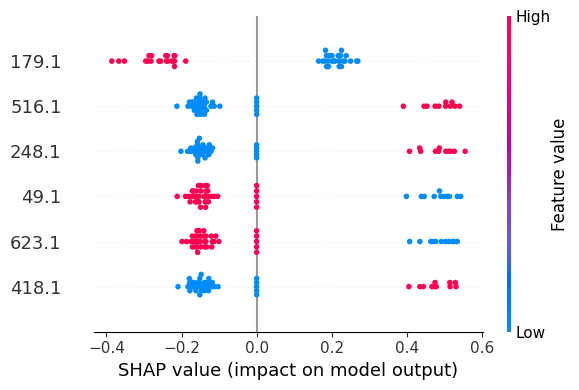

In [9]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(reg_best.predict, a_X_train)
shap_values = explainer.shap_values(a_X_train)
shap.summary_plot(shap_values, a_X_train,max_display=6,plot_size=(6,4))